# Przygotowanie

Zbiór potencjalnych danych:
  
  Klasyfikacja:

1. https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification
2. https://www.kaggle.com/datasets/fedesoriano/qmnist-the-extended-mnist-dataset-120k-images?select=MNIST-120k
3. https://archive.ics.uci.edu/ml/datasets/Secondary+Mushroom+Dataset

Regresja:

1. https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
2. https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29




In [1]:
'''import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime
print(remain / 3600)'''

'import time, psutil\nuptime = time.time() - psutil.boot_time()\nremain = 12*60*60 - uptime\nprint(remain / 3600)'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install shap
!pip install SALib
!pip install sklearn-relief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 758 kB 4.1 MB/s 
     |████████████████████████████████| 132 kB 50.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# importy ogólne
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output
from IPython.display import display, HTML
import pickle
import shap
import keras

# importy do modeli klasyfikacji
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# importy do sieci neuronowych keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Analiza danych

In [14]:
mushroom_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSets/secondary_data.csv", sep=';')
print(mushroom_data.info())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

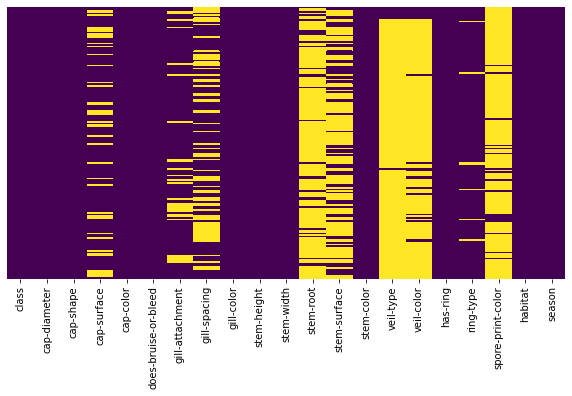

In [15]:
# sprawdzenie wartosci nan
plt.figure(figsize=(10, 5))
sns.heatmap(mushroom_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [16]:
mushroom_data.drop(columns=['gill-attachment', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'], inplace=True)
mushroom_data.dropna(axis=0,inplace=True)

In [17]:
# wyczyszczony zbiór danych
print(mushroom_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44831 entries, 0 to 61068
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 44831 non-null  object 
 1   cap-diameter          44831 non-null  float64
 2   cap-shape             44831 non-null  object 
 3   cap-surface           44831 non-null  object 
 4   cap-color             44831 non-null  object 
 5   does-bruise-or-bleed  44831 non-null  object 
 6   gill-color            44831 non-null  object 
 7   stem-height           44831 non-null  float64
 8   stem-width            44831 non-null  float64
 9   stem-color            44831 non-null  object 
 10  has-ring              44831 non-null  object 
 11  ring-type             44831 non-null  object 
 12  habitat               44831 non-null  object 
 13  season                44831 non-null  object 
dtypes: float64(3), object(11)
memory usage: 5.1+ MB
None


In [18]:
# sprawdzenie kolumn wartosci kategorycznych
cat_columns = [ 'cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-color','stem-color','has-ring','ring-type','habitat','season'] 
for col_name in cat_columns:
  mushroom_data[col_name] =  mushroom_data[col_name].apply(lambda s: f'{col_name}_{s}')


for col_name in cat_columns:
  print( mushroom_data[col_name].unique() )

['cap-shape_x' 'cap-shape_f' 'cap-shape_p' 'cap-shape_b' 'cap-shape_c'
 'cap-shape_s' 'cap-shape_o']
['cap-surface_g' 'cap-surface_h' 'cap-surface_t' 'cap-surface_y'
 'cap-surface_e' 'cap-surface_s' 'cap-surface_l' 'cap-surface_d'
 'cap-surface_w' 'cap-surface_i' 'cap-surface_k']
['cap-color_o' 'cap-color_e' 'cap-color_n' 'cap-color_r' 'cap-color_w'
 'cap-color_p' 'cap-color_y' 'cap-color_g' 'cap-color_b' 'cap-color_u'
 'cap-color_k' 'cap-color_l']
['does-bruise-or-bleed_f' 'does-bruise-or-bleed_t']
['gill-color_w' 'gill-color_n' 'gill-color_p' 'gill-color_e'
 'gill-color_y' 'gill-color_g' 'gill-color_u' 'gill-color_r'
 'gill-color_o' 'gill-color_k' 'gill-color_b' 'gill-color_f']
['stem-color_w' 'stem-color_n' 'stem-color_y' 'stem-color_e'
 'stem-color_k' 'stem-color_g' 'stem-color_u' 'stem-color_o'
 'stem-color_r' 'stem-color_p' 'stem-color_l' 'stem-color_f']
['has-ring_t' 'has-ring_f']
['ring-type_g' 'ring-type_p' 'ring-type_l' 'ring-type_e' 'ring-type_f'
 'ring-type_m' 'ring-type_r'

In [19]:
Y = mushroom_data['class']
Y = pd.get_dummies(Y, drop_first=True)
X = mushroom_data[['cap-diameter', 'stem-height', 'stem-width']]

dummies_list = [
                X,
                pd.get_dummies(mushroom_data['has-ring'], drop_first=False),
                pd.get_dummies(mushroom_data['season'], drop_first=False),  
                pd.get_dummies(mushroom_data['habitat'], drop_first=False),
                pd.get_dummies(mushroom_data['ring-type'], drop_first=False),
                pd.get_dummies(mushroom_data['cap-shape'],drop_first=False),
                pd.get_dummies(mushroom_data['cap-surface'],drop_first=False),
                pd.get_dummies(mushroom_data['cap-color'],drop_first=False),
                pd.get_dummies(mushroom_data['gill-color'],drop_first=False),
                pd.get_dummies(mushroom_data['stem-color'],drop_first=False)
                ] 
X = pd.concat(dummies_list, axis=1, ignore_index=False)
print(X)

       cap-diameter  stem-height  stem-width  has-ring_f  has-ring_t  \
0             15.26        16.95       17.09           0           1   
1             16.60        17.99       18.19           0           1   
2             14.07        17.80       17.74           0           1   
3             14.17        15.77       15.98           0           1   
4             14.64        16.53       17.20           0           1   
...             ...          ...         ...         ...         ...   
61064          1.18         3.93        6.22           1           0   
61065          1.27         3.18        5.43           1           0   
61066          1.27         3.86        6.37           1           0   
61067          1.24         3.56        5.44           1           0   
61068          1.17         3.25        5.45           1           0   

       season_a  season_s  season_u  season_w  habitat_d  ...  stem-color_g  \
0             0         0         0         1          1

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, random_state=101)
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=X.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=X.columns)
print(x_train)

       cap-diameter  stem-height  stem-width  has-ring_f  has-ring_t  \
0          0.109585     0.169811    0.138774         1.0         0.0   
1          0.135769     0.222583    0.128958         1.0         0.0   
2          0.182156     0.156250    0.163026         1.0         0.0   
3          0.312106     0.208432    0.248292         1.0         0.0   
4          0.053823     0.118219    0.030026         1.0         0.0   
...             ...          ...         ...         ...         ...   
22410      0.127041     0.279776    0.226638         1.0         0.0   
22411      0.006465     0.132665    0.010875         1.0         0.0   
22412      0.014223     0.179540    0.018478         1.0         0.0   
22413      0.106999     0.142689    0.163507         1.0         0.0   
22414      0.117666     0.189858    0.167356         1.0         0.0   

       season_a  season_s  season_u  season_w  habitat_d  ...  stem-color_g  \
0           1.0       0.0       0.0       0.0        1.0

# Model drzewa decyzyjnego

In [ ]:
# model drzewa decyzyjnego
dtree_model = DecisionTreeClassifier(max_depth=16)
dtree_model.fit(x_train, y_train)
y_pred = dtree_model.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9698
           1       0.98      0.98      0.98     12718

    accuracy                           0.98     22416
   macro avg       0.98      0.98      0.98     22416
weighted avg       0.98      0.98      0.98     22416

[[ 9473   225]
 [  212 12506]]


In [ ]:
pickle.dump( dtree_model, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_DTREE.sav', 'wb') )

# Model randomowego lasu

In [ ]:
# model randomowego lasu
forest_model = RandomForestClassifier(n_estimators=200)
forest_model.fit(x_train, y_train.values.ravel())
y_pred = forest_model.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9698
           1       1.00      1.00      1.00     12718

    accuracy                           1.00     22416
   macro avg       1.00      1.00      1.00     22416
weighted avg       1.00      1.00      1.00     22416

[[ 9692     6]
 [    5 12713]]


In [ ]:
pickle.dump( forest_model, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_RFOREST.sav', 'wb') )

# Model SVM

In [ ]:
start = timer()
grid_param = { 'C':[1, 10, 100, 1000, 10000], 'gamma' : [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'linear', 'poly']}
grid = GridSearchCV(SVC(), grid_param, refit=True, verbose=True)
grid.fit(x_train.values, y_train.values.ravel())
print(grid.best_params_)
end = timer()
print( f'time: {end-start}')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
time: 9826.222760666


In [ ]:
grid_param = { 'C': [900, 1000, 1100], 'gamma': [0.15, 0.1, .05], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), grid_param, refit=True, verbose=True)
grid.fit(x_train.values, y_train.values.ravel())
print( grid.best_params_ )

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 900, 'gamma': 0.15, 'kernel': 'rbf'}


In [ ]:
grid_param = { 'C': [800, 900, 950], 'gamma': [0.2, 0.15, 0.1], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), grid_param, refit=True, verbose=True)
grid.fit(x_train.values, y_train.values.ravel())
print( grid.best_params_ )

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 800, 'gamma': 0.2, 'kernel': 'rbf'}


In [ ]:
grid_param = { 'C': [600, 700, 800], 'gamma': [0.35, 0.3, 0.2], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), grid_param, refit=True, verbose=True)
grid.fit(x_train.values, y_train.values.ravel())
print( grid.best_params_ )

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 700, 'gamma': 0.3, 'kernel': 'rbf'}


In [ ]:
svm_model = SVC(C=700, gamma=0.3, kernel='rbf', probability=True)
svm_model.fit( x_train.values, y_train.values.ravel() )
y_pred = svm_model.predict(x_test.values)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9698
           1       1.00      1.00      1.00     12718

    accuracy                           1.00     22416
   macro avg       1.00      1.00      1.00     22416
weighted avg       1.00      1.00      1.00     22416

[[ 9692     6]
 [   14 12704]]


In [ ]:
pickle.dump( svm_model, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_SVM.sav', 'wb') )

# Model MLP

In [ ]:
# budowanie modelu sieci 
nn_model = Sequential()
nn_model.add( Dense(71, input_dim=len(x_train.columns),  activation='relu') )
nn_model.add( Dense(50, activation='relu') )
nn_model.add( Dense(20, activation='relu') )
nn_model.add( Dense(1, activation='sigmoid') )

nn_model.compile(optimizer='adam', loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [ ]:
nn_model.fit(x_train,
          y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stop]
         )

Epoch 1/50
88/88 [==============================] - 1s 8ms/step - loss: 0.4851 - val_loss: 0.2880
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1730 - val_loss: 0.0961
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0691 - val_loss: 0.0535
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0366
Epoch 6/50
88/88 [==============================] - 1s 8ms/step - loss: 0.0311 - val_loss: 0.0359
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0319 - val_loss: 0.0296
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0272 - val_loss: 0.0278
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0241 - val_loss: 0.0257
Epoch 10/50
88/88 [==============================] - 1s 6ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 11/50
88/88 [

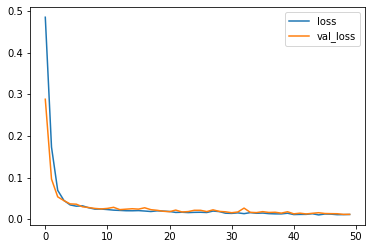

In [ ]:
history = pd.DataFrame(nn_model.history.history)
history.plot()

In [ ]:
y_pred = nn_model.predict(x_test)
y_pred = (y_pred >= 0.5) * 1
print( confusion_matrix(y_test, y_pred) )
print( classification_report(y_test, y_pred) ) 

701/701 [==============================] - 1s 1ms/step
[[ 9670    28]
 [   40 12678]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9698
           1       1.00      1.00      1.00     12718

    accuracy                           1.00     22416
   macro avg       1.00      1.00      1.00     22416
weighted avg       1.00      1.00      1.00     22416



In [ ]:
nn_model.save('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_MLP')

# Analiza istotności

In [ ]:
#Ksamples = shap.sample(x_train, 100)
Ksamples = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Ksamples.sav', 'rb') )


from IPython.display import clear_output
from SALib.analyze import morris
from SALib.analyze import sobol 
from SALib.sample import saltelli
import tensorflow as tf
import math

import shap
from sklearn_relief import Relief

bounds = [ [0, 1] for x in x_train.columns.values ]
problem = {
    'num_vars' : len(x_train.columns),
    'names' : list(x_train.columns),
    'bounds' : bounds
}
print( np.array(bounds).shape )

# funkcja resetująca wagi modelu mlp na losowe wartości
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))


# funkcja licząca morris
def get_morris_features(X, Y, problem):
  r_sum_elementary_effects = []

  amount_of_classes = 1
  if( len(Y.shape)==2 ):
    amount_of_classes = Y.shape[-1]
  Y_numpy = np.array(Y).reshape(-1, amount_of_classes)
  X_numpy = np.array(X)

  for g_class in range( amount_of_classes ):
    morris._define_problem_with_groups(problem)

    delta = morris._compute_delta(4)

    num_vars = problem["num_vars"]
    groups = morris._check_groups(problem)
    if not groups:
        number_of_groups = num_vars
    else:
        groups, unique_group_names = morris.compute_groups_matrix(groups)
        number_of_groups = len(set(unique_group_names))

    num_trajectories = int(Y_numpy[:, g_class].size / (number_of_groups + 1))
    trajectory_size = int(Y_numpy[:, g_class].size / num_trajectories)

    elementary_effects = morris._compute_elementary_effects(X_numpy, Y_numpy[:, g_class], trajectory_size, delta)
    P = elementary_effects.shape[-1]
    elementary_effects = np.sqrt(np.sum(np.power(elementary_effects, 2), axis=1) / P)
    r_sum_elementary_effects.append( elementary_effects )
    
  r_sum_elementary_effects = np.max(np.array(r_sum_elementary_effects), axis=0)

  features_morris = pd.DataFrame( r_sum_elementary_effects, columns=['waga'], index=problem['names'] )
  features_morris.sort_values('waga', ascending=True, inplace=True)
  return features_morris



def evaluate_models(features, models, params_for_model_fitting = {}, model_builder=None, amounts=10) -> None:
  '''
  funkcja mająca na celu wytrenować kolejny model z listy
  używając co iteracje nowego modelu i pomniejszonej liczby atrybutów.
  Na sam koniec wyrysowując dopasowanie modelu i 
  wypisując sqrt(mse) oraz mae
  '''

  # zbiór danych do odrzucania najmniej znaczącyh
  relief_x_train = x_train
  relief_x_test = x_test
  model_avg_scores = []

  for i, model in enumerate(models):
    # usunięcie kolejnego atrybutu
    if( i > 0 ):
      relief_x_train = relief_x_train.drop( features.index[i-1], axis=1 )
      relief_x_test = relief_x_test.drop( features.index[i-1], axis=1 )

    # wytrenowanie modelu 10-krotnie i zebranie wartości błędu
    scores = []
    best_weights_for_mlp = None
    for dummie in range(amounts):
      if (model_builder):
        model = model_builder()
        model.fit(relief_x_train, y_train.values.ravel())
      else:
        reinitialize(model)
        model.fit(relief_x_train, y_train, **params_for_model_fitting)
      y_pred = model.predict(relief_x_test)
      y_pred = (y_pred >= 0.5) * 1

      score = pd.DataFrame( classification_report(y_test, y_pred, output_dict=True) ).drop('weighted avg', axis=1).drop('support', axis=0)
      scores.append( score )  
      print(f'Uczę {dummie}-ty model dla {len(relief_x_train.columns.values)} atrybutów')
      clear_output(wait=True)
      
    model_avg_scores.append( [sum(scores)/ len(scores), len(relief_x_train.columns.values)] )


  # napis z metrykami
  print( "########## AVG SCORES ########")
  for avg_s in model_avg_scores:
    print( f'ilość atrybutów: {avg_s[1]}')
    print( avg_s[0] )
    print()
  print( "########## AVG SCORES ########")

  f1_score = [ x[0].loc['f1-score']['macro avg'] for x in model_avg_scores ]
  attr = range(len(features), 0, -1)
  plt.figure( figsize=(10, 5) )
  plt.xlim(max(attr), min(attr))
  plt.title('Wykres metryki f1-score od ilości atrybutów')
  plt.xlabel('Liczba atrybutów')
  plt.ylabel('f1-score')
  sns.lineplot(x=attr, y=f1_score, marker='o', linestyle='--')
  


# klasy zwracające instancje modelów 
class dtree_builder:
  def __call__(self):
    return DecisionTreeClassifier( max_depth=16 )

class rforest_builder:
  def __call__(self):
    return RandomForestClassifier(n_estimators=200)

class svm_builder:
  def __call__(self):
    return SVC(C=700, gamma=0.3, kernel='rbf', probability=True)

def create_mlp(in_dim):
  nn_model = Sequential()
  nn_model.add( Dense(71, input_dim=in_dim,  activation='relu') )
  nn_model.add( Dense(50, activation='relu') )
  nn_model.add( Dense(20, activation='relu') )
  nn_model.add( Dense(1, activation='sigmoid') )
  nn_model.compile(optimizer='adam', loss='binary_crossentropy')
  return nn_model

early_stop = EarlyStopping(monitor='loss', patience=10, mode='min')
mlp_params = {'verbose':0, 'epochs':50, 'batch_size':256, 'callbacks':[early_stop] }


attributes_dict = {}
for i, attr in enumerate(x_train.columns.values):
  attributes_dict[attr] = str(i)
  print(f'{attr} : {i}')

(78, 2)
cap-diameter : 0
stem-height : 1
stem-width : 2
has-ring_f : 3
has-ring_t : 4
season_a : 5
season_s : 6
season_u : 7
season_w : 8
habitat_d : 9
habitat_g : 10
habitat_h : 11
habitat_l : 12
habitat_m : 13
habitat_u : 14
habitat_w : 15
ring-type_e : 16
ring-type_f : 17
ring-type_g : 18
ring-type_l : 19
ring-type_m : 20
ring-type_p : 21
ring-type_r : 22
ring-type_z : 23
cap-shape_b : 24
cap-shape_c : 25
cap-shape_f : 26
cap-shape_o : 27
cap-shape_p : 28
cap-shape_s : 29
cap-shape_x : 30
cap-surface_d : 31
cap-surface_e : 32
cap-surface_g : 33
cap-surface_h : 34
cap-surface_i : 35
cap-surface_k : 36
cap-surface_l : 37
cap-surface_s : 38
cap-surface_t : 39
cap-surface_w : 40
cap-surface_y : 41
cap-color_b : 42
cap-color_e : 43
cap-color_g : 44
cap-color_k : 45
cap-color_l : 46
cap-color_n : 47
cap-color_o : 48
cap-color_p : 49
cap-color_r : 50
cap-color_u : 51
cap-color_w : 52
cap-color_y : 53
gill-color_b : 54
gill-color_e : 55
gill-color_f : 56
gill-color_g : 57
gill-color_k : 58


In [ ]:
#param_values = saltelli.sample(problem, 4096)
#pickle.dump(param_values, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/param_values.sav', 'wb'))
param_values = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/param_values.sav', 'rb'))

# 0. Analiza Relief

In [ ]:
from sklearn_relief import Relief

Text(0.5, 0, 'numer atrybutu')

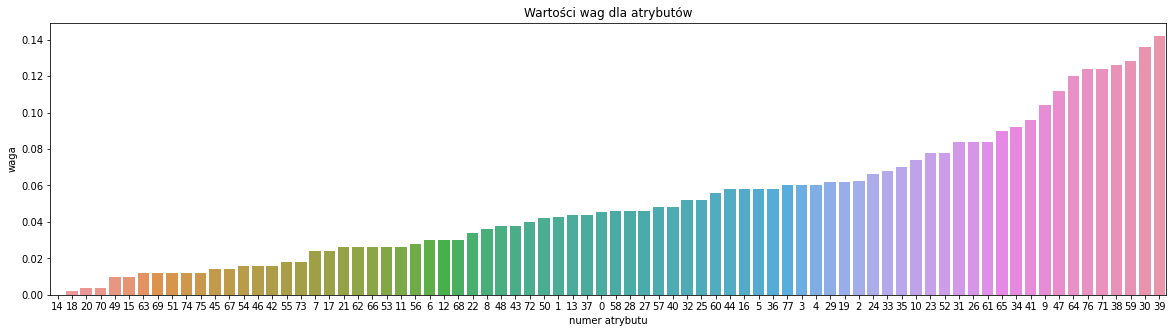

In [ ]:
rel = Relief(n_features=20, n_iterations=500)
rel.fit(x_train.values, y_train.values.ravel())

features_relief = np.abs(rel.w_)
x_columns = x_train.columns

fig, ax = plt.subplots(figsize=(20, 5))
features_relief = pd.DataFrame(features_relief.reshape(-1, 1), index=x_columns, columns=['waga'])
features_relief.sort_values('waga', ascending=True, inplace=True)
pickle.dump(features_relief, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_relief.sav', 'wb'))

x_nums = [ attributes_dict[col] for col in features_relief.index ]
sns.barplot(data=features_relief, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

Model Drzewa Decyzyjnego

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.978294  0.982021  0.980411   0.980157
recall     0.976387  0.983480  0.980411   0.979933
f1-score   0.977339  0.982750  0.980411   0.980045

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.978235  0.982105  0.980434   0.980170
recall     0.976500  0.983433  0.980434   0.979967
f1-score   0.977367  0.982768  0.980434   0.980068

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.978657  0.982018  0.980567   0.980338
recall     0.976377  0.983763  0.980567   0.980070
f1-score   0.977516  0.982890  0.980567   0.980203

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.978743  0.982173  0.980692   0.980458
recall     0.976583  0.983826  0.980692   0.980204
f1-score   0.977661  0.982999  0.980692   0.980330

ilość atrybutów: 74
                  0         1  accuracy  macro av

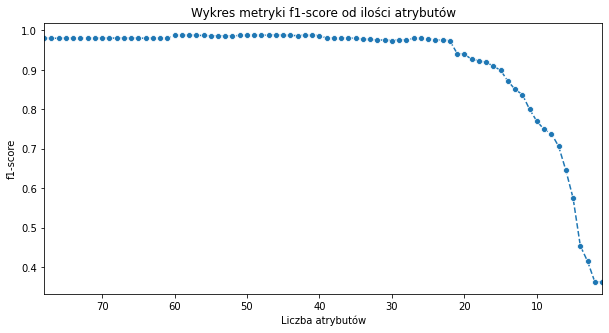

In [ ]:
dtree_models = [ x for x in range( len(features_relief) ) ]
evaluate_models(features_relief, dtree_models, model_builder=dtree_builder(), amounts=10)

Model Randomowych Lasów

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.999402  0.999426  0.999416   0.999414
recall     0.999247  0.999544  0.999416   0.999396
f1-score   0.999325  0.999485  0.999416   0.999405

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.999340  0.999457  0.999407   0.999399
recall     0.999289  0.999497  0.999407   0.999393
f1-score   0.999314  0.999477  0.999407   0.999396

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.999319  0.999442  0.999389   0.999381
recall     0.999268  0.999481  0.999389   0.999374
f1-score   0.999294  0.999461  0.999389   0.999378

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.999361  0.999442  0.999407   0.999401
recall     0.999268  0.999513  0.999407   0.999390
f1-score   0.999314  0.999477  0.999407   0.999396

ilość atrybutów: 74
                  0         1  accuracy  macro av

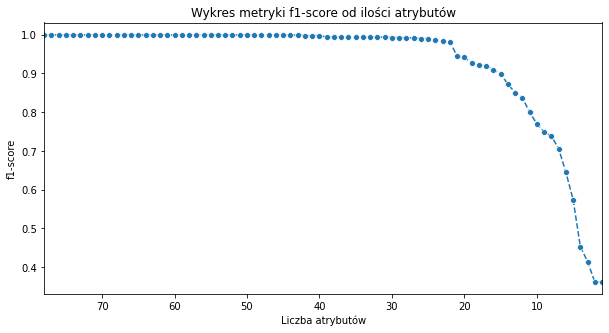

In [ ]:
rforest_models = [ x for x in range( len(features_relief) ) ]
evaluate_models(features_relief, rforest_models, model_builder=rforest_builder(), amounts=10)

Model SVM

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 74
                  0         1  accuracy  macro av

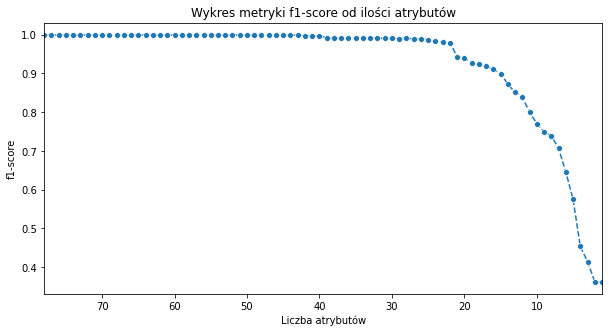

In [ ]:
# prces uczenia svm nie jest losowy więc wystarczy jedno powtórzenie 
svm_models = [ x for x in range( len(features_relief) ) ]
evaluate_models(features_relief, svm_models, model_builder=svm_builder(), amounts=1)

Model MLP

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.994113  0.996477  0.995441   0.995295
recall     0.995370  0.995495  0.995441   0.995432
f1-score   0.994733  0.995981  0.995441   0.995357

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.991767  0.997628  0.995062   0.994697
recall     0.996896  0.993663  0.995062   0.995279
f1-score   0.994314  0.995635  0.995062   0.994975

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.994138  0.995315  0.994781   0.994727
recall     0.993823  0.995510  0.994781   0.994667
f1-score   0.993963  0.995403  0.994781   0.994683

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.992927  0.996332  0.994839   0.994630
recall     0.995185  0.994575  0.994839   0.994880
f1-score   0.994044  0.995446  0.994839   0.994745

ilość atrybutów: 74
                  0         1  accuracy  macro av

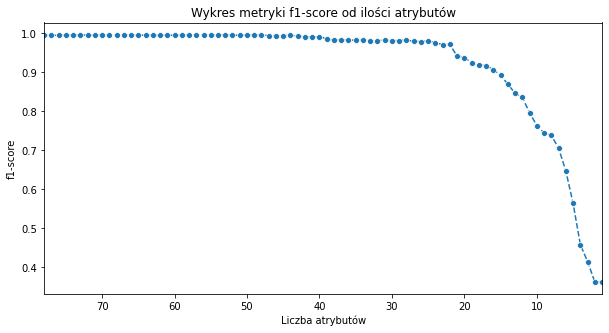

In [ ]:
mlp_models = []
for i in range( len(features_relief) ):
  mlp_models.append( create_mlp( len(features_relief)-i ) )

evaluate_models(features_relief, mlp_models, params_for_model_fitting=mlp_params, amounts=10)

# 1. Drzewo decyzyjne

In [ ]:
dtree_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_DTREE.sav', 'rb'))

In [ ]:
dtree_shap_values = shap.TreeExplainer(dtree_model, Ksamples).shap_values(Ksamples)

In [ ]:
vals = np.array(dtree_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )
pickle.dump(features_shap, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_shap_dtree.sav', 'wb'))

                   waga
name                   
cap-diameter   0.000000
gill-color_b   0.000000
cap-color_y    0.000000
cap-color_w    0.000000
cap-color_u    0.000000
...                 ...
cap-shape_p    0.000000
stem-color_y   0.000000
ring-type_z    1.623542
stem-color_g   1.933943
stem-width    12.692328

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

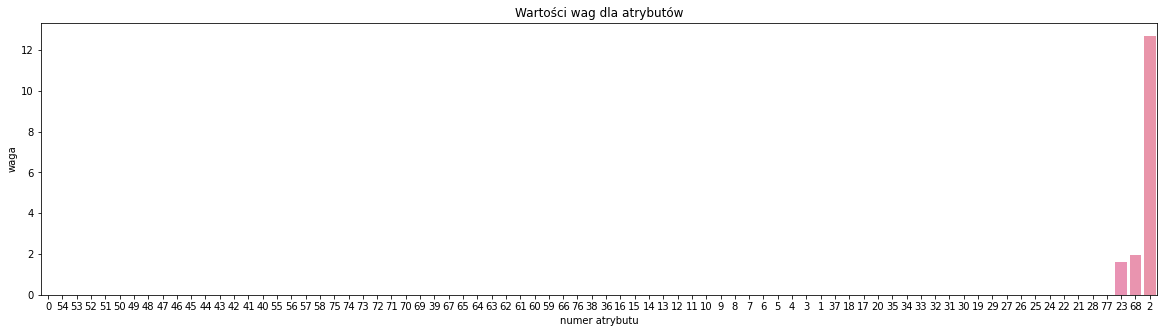

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.978606  0.981987  0.980527   0.980296
recall     0.976335  0.983724  0.980527   0.980030
f1-score   0.977469  0.982854  0.980527   0.980162

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.881650  0.993117  0.938865   0.937383
recall     0.991833  0.898475  0.938865   0.945154
f1-score   0.933502  0.943428  0.938865   0.938465

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.881661  0.993074  0.938852   0.937367
recall     0.991782  0.898490  0.938852   0.945136
f1-score   0.933485  0.943417  0.938852   0.938451

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.881663  0.993091  0.938861   0.937377
recall     0.991802  0.898490  0.938861   0.945146
f1-score   0.933495  0.943425  0.938861   0.938460

ilość atrybutów: 74
                  0         1  accuracy  macro av

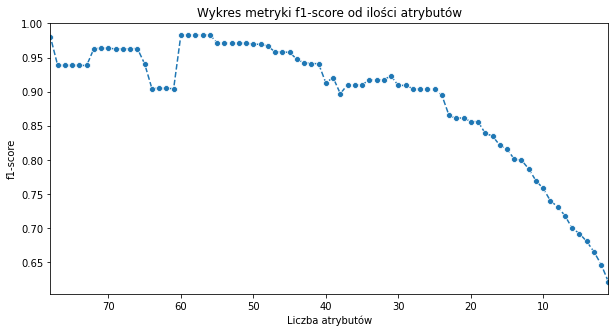

In [ ]:
dtree_models = [ x for x in range( len(features_shap) ) ]
evaluate_models(features_shap, dtree_models, model_builder=dtree_builder(), amounts=10)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = dtree_model.predict_proba(X)

In [ ]:
features_morris = get_morris_features(X, Y, problem)
print( features_morris )
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_morris_dtree.sav', 'wb'))

                   waga
cap-diameter   0.796829
stem-color_y   0.796914
gill-color_g   1.124793
cap-shape_p    1.124952
ring-type_r    1.125613
...                 ...
stem-color_w   1.126947
cap-surface_w  1.126947
stem-color_g   1.153592
stem-width     1.199182
ring-type_z    1.393894

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

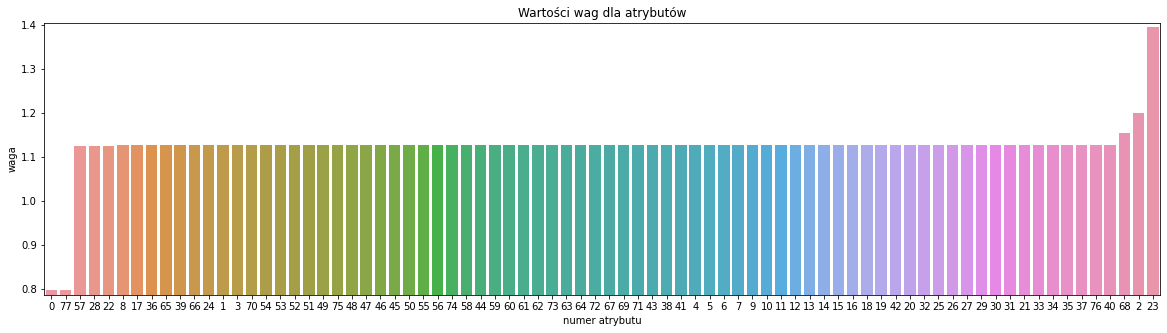

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_ylim([features_morris['waga'].min() - 0.01, features_morris['waga'].max() + 0.01])
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.978469  0.982131   0.98055   0.980300
recall     0.976531  0.983614   0.98055   0.980073
f1-score   0.977499  0.982872   0.98055   0.980185

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.881615  0.993030  0.938807   0.937323
recall     0.991730  0.898451  0.938807   0.945091
f1-score   0.933436  0.943376  0.938807   0.938406

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.919555  0.973069  0.948746   0.946312
recall     0.966045  0.935556  0.948746   0.950800
f1-score   0.942227  0.953944  0.948746   0.948085

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.919388  0.972930  0.948595   0.946159
recall     0.965869  0.935422  0.948595   0.950646
f1-score   0.942056  0.953808  0.948595   0.947932

ilość atrybutów: 74
                  0         1  accuracy  macro av

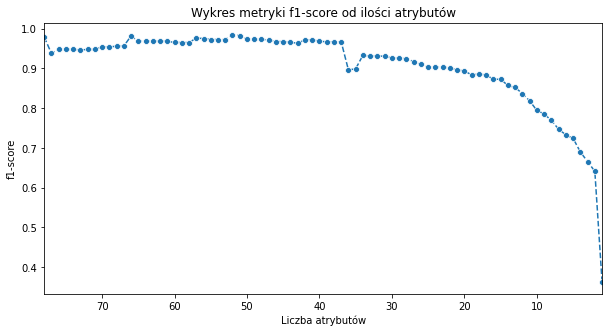

In [ ]:
evaluate_models(features_morris, dtree_models, model_builder=dtree_builder(), amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['ST'] )

features_sobol = np.abs(np.array(features_sobol))
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_sobol_dtree.sav', 'wb'))

                  waga
cap-diameter  0.000000
gill-color_b  0.000000
cap-color_y   0.000000
cap-color_w   0.000000
cap-color_u   0.000000
...                ...
cap-shape_p   0.000000
stem-color_y  0.000000
stem-color_g  0.077264
stem-width    0.214386
ring-type_z   0.855062

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

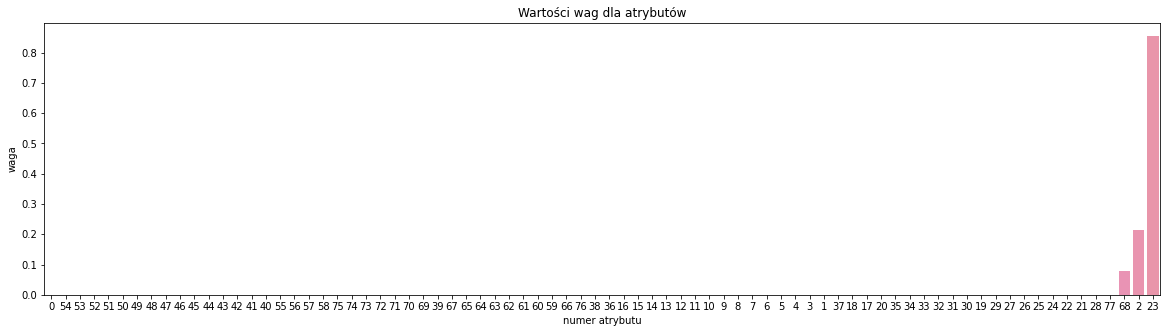

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
#ax.set_ylim([features_morris['waga'].min() - 0.01, features_morris['waga'].max() + 0.01])
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.978638  0.982064  0.980585   0.980351
recall     0.976438  0.983747  0.980585   0.980093
f1-score   0.977537  0.982905  0.980585   0.980221

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.881709  0.993134  0.938905   0.937421
recall     0.991854  0.898530  0.938905   0.945192
f1-score   0.933544  0.943466  0.938905   0.938505

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.881641  0.993108  0.938856   0.937374
recall     0.991823  0.898467  0.938856   0.945145
f1-score   0.933492  0.943420  0.938856   0.938456

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.881642  0.992987  0.938803   0.937314
recall     0.991679  0.898482  0.938803   0.945081
f1-score   0.933428  0.943374  0.938803   0.938401

ilość atrybutów: 74
                  0         1  accuracy  macro av

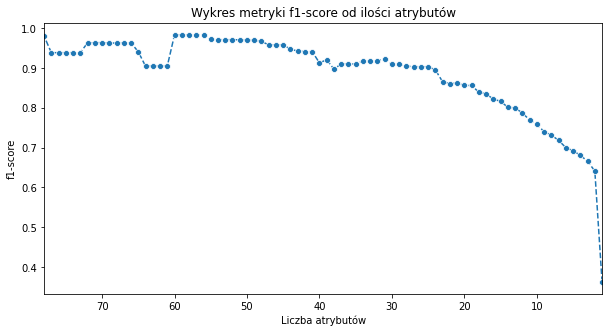

In [ ]:
evaluate_models(features_sobol, dtree_models, model_builder=dtree_builder(), amounts=10)

# 2. Randomowe Lasy

In [ ]:
rforest_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_RFOREST.sav', 'rb'))

Shap

In [ ]:
rforest_shap_values = shap.TreeExplainer(rforest_model, Ksamples).shap_values(Ksamples, check_additivity=False)

 98%|===================| 197/200 [00:15<00:00]       

In [ ]:
vals = np.array(rforest_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )
pickle.dump(features_shap, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_shap_rforest.sav', 'wb'))

                  waga
name                  
habitat_w     0.000000
gill-color_e  0.000000
ring-type_m   0.000000
ring-type_l   0.000000
ring-type_g   0.000000
...                ...
stem-height   2.508154
cap-diameter  2.779348
cap-color_n   3.362512
stem-width    6.093915
stem-color_w  6.247696

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

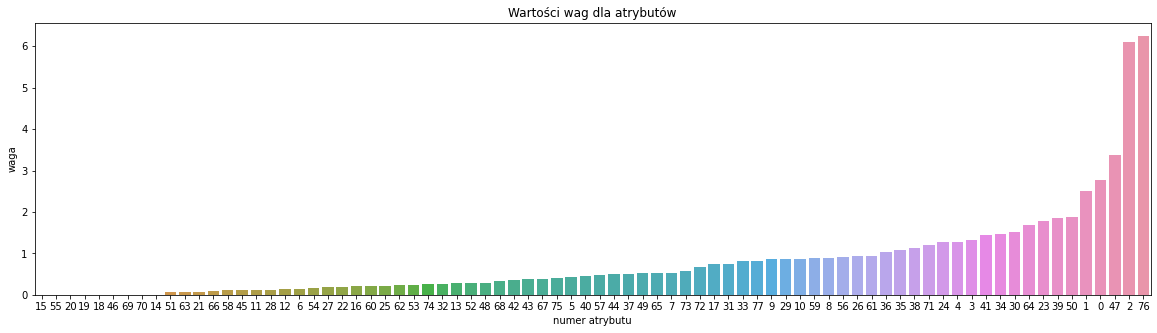

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.999299  0.999442   0.99938   0.999370
recall     0.999268  0.999465   0.99938   0.999367
f1-score   0.999283  0.999454   0.99938   0.999368

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.999330  0.999434  0.999389   0.999382
recall     0.999258  0.999489  0.999389   0.999373
f1-score   0.999294  0.999461  0.999389   0.999378

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.999340  0.999442  0.999398   0.999391
recall     0.999268  0.999497  0.999398   0.999382
f1-score   0.999304  0.999469  0.999398   0.999387

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.999319  0.999387  0.999358   0.999353
recall     0.999196  0.999481  0.999358   0.999338
f1-score   0.999258  0.999434  0.999358   0.999346

ilość atrybutów: 74
                  0         1  accuracy  macro av

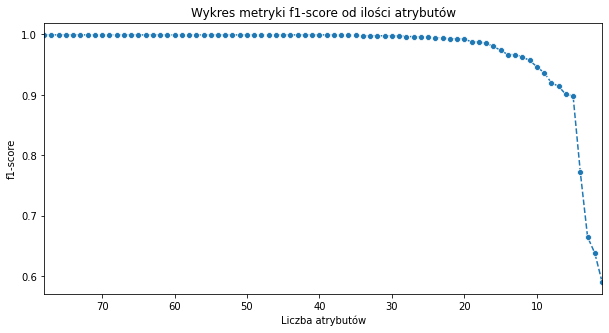

In [ ]:
rforest_models = [ x for x in range( len(features_shap) ) ]
evaluate_models(features_shap, rforest_models, model_builder=rforest_builder(), amounts=10)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = rforest_model.predict_proba(X)

In [ ]:
features_morris = get_morris_features(X, Y, problem)
print( features_morris )
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_morris_rforest.sav', 'wb'))

                   waga
stem-color_y   0.650577
cap-diameter   0.650846
gill-color_g   0.917245
cap-shape_p    0.917308
ring-type_f    0.917931
...                 ...
cap-color_b    0.920469
cap-color_r    0.920535
cap-shape_b    0.920591
cap-surface_k  0.924349
ring-type_z    0.929227

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

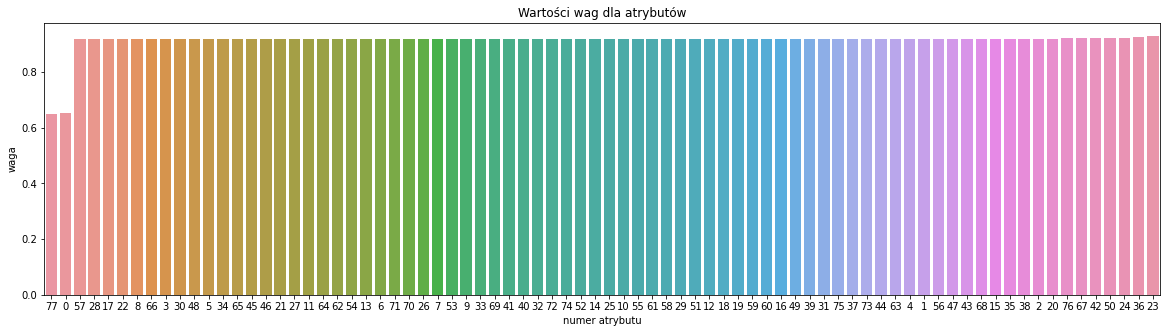

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.999340  0.999489  0.999425   0.999415
recall     0.999330  0.999497  0.999425   0.999413
f1-score   0.999335  0.999493  0.999425   0.999414

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.999309  0.999418  0.999371   0.999364
recall     0.999237  0.999473  0.999371   0.999355
f1-score   0.999273  0.999446  0.999371   0.999359

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.998743  0.999363  0.999094   0.999053
recall     0.999165  0.999041  0.999094   0.999103
f1-score   0.998954  0.999202  0.999094   0.999078

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.998784  0.999269  0.999059   0.999026
recall     0.999041  0.999072  0.999059   0.999057
f1-score   0.998912  0.999170  0.999059   0.999041

ilość atrybutów: 74
                  0         1  accuracy  macro av

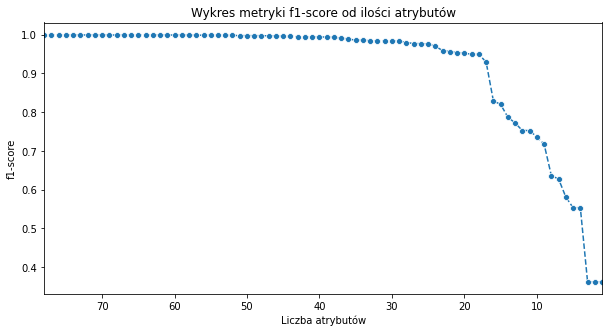

In [ ]:
evaluate_models(features_morris, rforest_models, model_builder=rforest_builder(), amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['ST'] )

features_sobol = np.abs(np.array(features_sobol))
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_sobol_rforest.sav', 'wb'))

                   waga
habitat_u      0.000086
stem-color_l   0.000374
season_s       0.000560
gill-color_k   0.000803
stem-color_o   0.000915
...                 ...
stem-color_f   0.042666
cap-shape_b    0.055681
cap-color_r    0.059509
cap-surface_k  0.184853
ring-type_z    0.305973

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

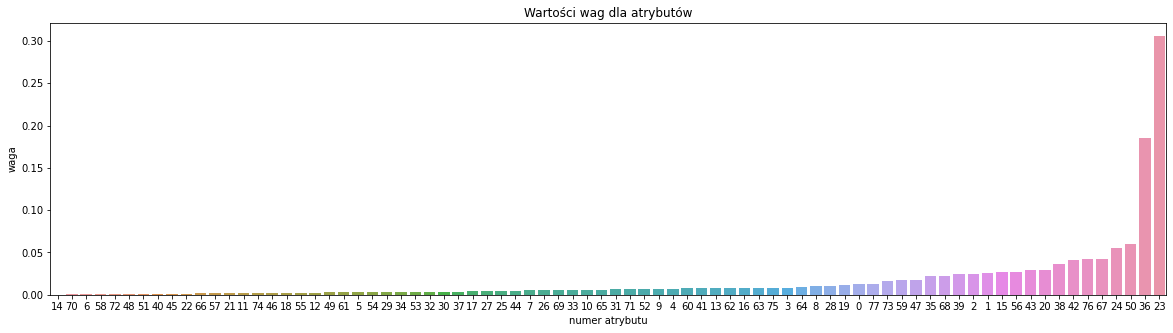

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.999350  0.999450  0.999407   0.999400
recall     0.999278  0.999505  0.999407   0.999391
f1-score   0.999314  0.999477  0.999407   0.999396

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.999330  0.999418   0.99938   0.999374
recall     0.999237  0.999489   0.99938   0.999363
f1-score   0.999283  0.999454   0.99938   0.999368

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.999361  0.999465   0.99942   0.999413
recall     0.999299  0.999513   0.99942   0.999406
f1-score   0.999330  0.999489   0.99942   0.999409

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.999288  0.999426  0.999367   0.999357
recall     0.999247  0.999457  0.999367   0.999352
f1-score   0.999268  0.999442  0.999367   0.999355

ilość atrybutów: 74
                  0         1  accuracy  macro av

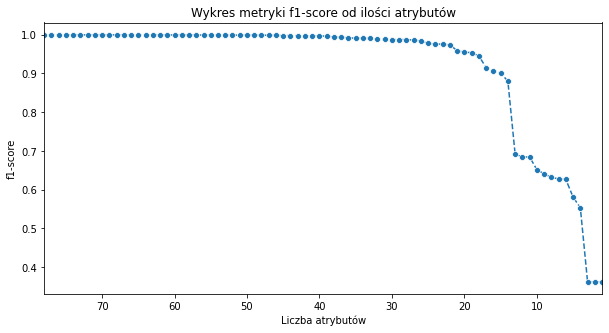

In [ ]:
evaluate_models(features_sobol, rforest_models, model_builder=rforest_builder(), amounts=10)

#  3. SVM

In [ ]:
svm_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_SVM.sav', 'rb'))

Shap

In [ ]:
svm_shap_values = shap.KernelExplainer(svm_model.predict_proba, Ksamples).shap_values(Ksamples)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
vals = np.array(svm_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )
pickle.dump(features_shap, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_shap_svm.sav', 'wb'))

                  waga
name                  
stem-color_l  0.000000
habitat_w     0.000000
habitat_u     0.000000
ring-type_m   0.000000
ring-type_l   0.000000
...                ...
cap-shape_x   3.928692
cap-color_n   4.170284
stem-width    5.452491
cap-diameter  8.263425
stem-color_w  9.407418

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

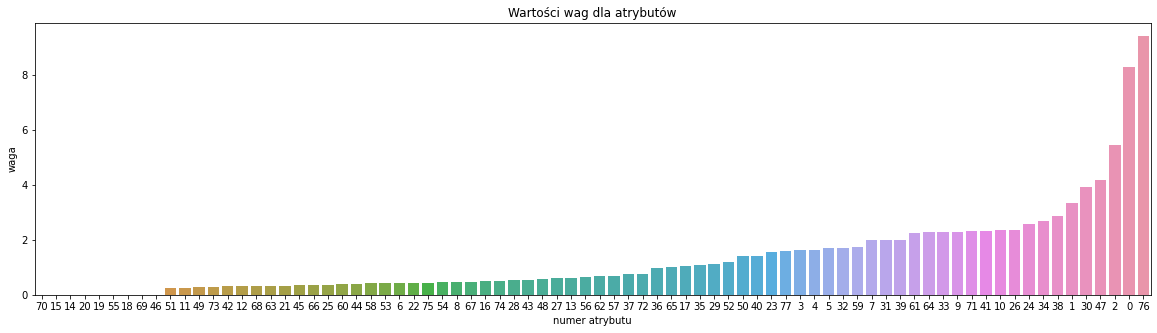

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 74
                  0         1  accuracy  macro av

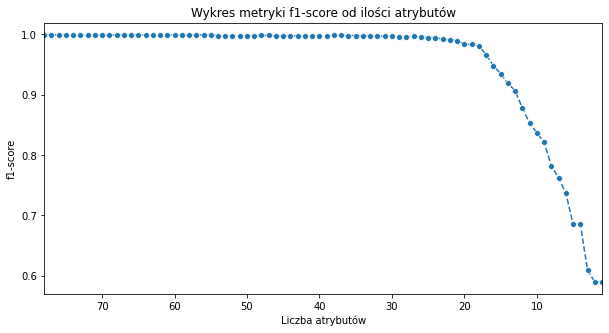

In [ ]:
svm_models = [ x for x in range( len(features_shap) ) ]
evaluate_models(features_shap, svm_models, model_builder=svm_builder(), amounts=1)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = svm_model.predict_proba(X)

X has feature names, but SVC was fitted without feature names


In [ ]:
features_morris = get_morris_features(X, Y, problem)
print( features_morris )
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_morris_svm.sav', 'wb'))

                   waga
stem-color_y   0.844334
cap-diameter   0.845624
gill-color_g   1.191682
cap-shape_p    1.191869
ring-type_f    1.192915
...                 ...
cap-surface_s  1.194325
gill-color_n   1.194351
stem-width     1.194428
cap-surface_g  1.194752
stem-height    1.195328

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

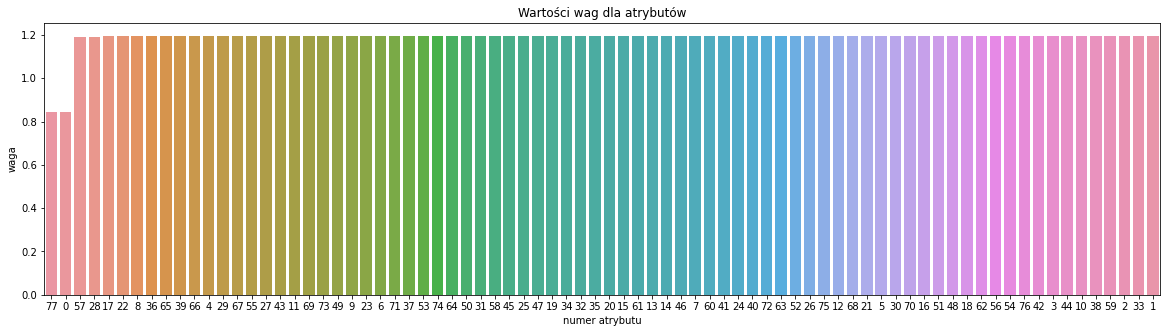

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.996907  0.997641  0.997323   0.997274
recall     0.996907  0.997641  0.997323   0.997274
f1-score   0.996907  0.997641  0.997323   0.997274

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.996907  0.997641  0.997323   0.997274
recall     0.996907  0.997641  0.997323   0.997274
f1-score   0.996907  0.997641  0.997323   0.997274

ilość atrybutów: 74
                  0         1  accuracy  macro av

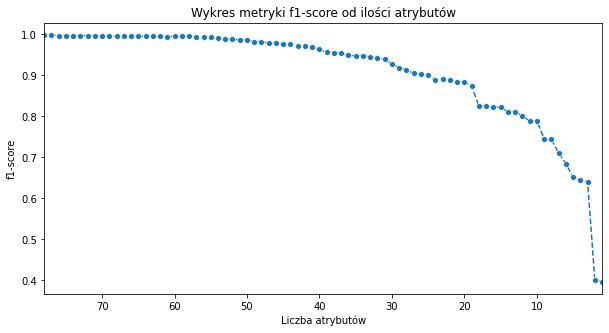

In [ ]:
svm_models = [ x for x in range( len(features_morris) ) ]
evaluate_models(features_morris, svm_models, model_builder=svm_builder(), amounts=1)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['ST'] )

features_sobol = np.abs(np.array(features_sobol))
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_sobol_svm.sav', 'wb'))

                   waga
season_a       0.002477
season_u       0.002762
gill-color_u   0.006135
stem-color_k   0.006298
stem-color_r   0.006380
...                 ...
cap-surface_s  0.060324
stem-width     0.131255
cap-surface_g  0.141386
stem-height    0.173840
cap-diameter   0.175950

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

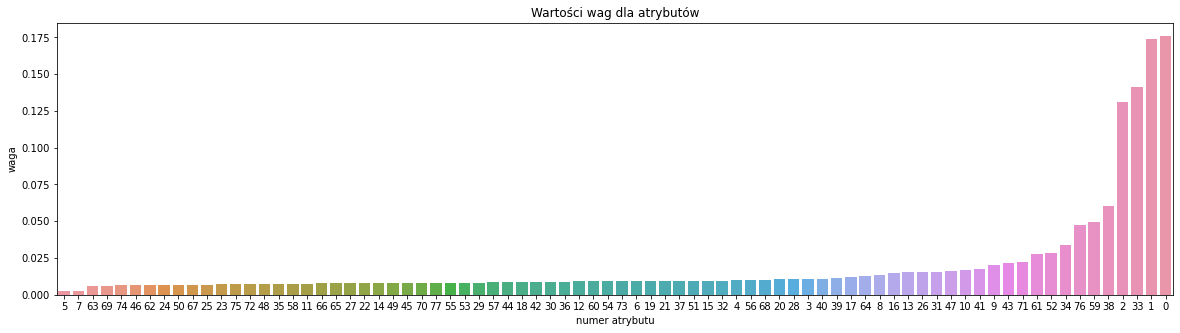

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.998558  0.999528  0.999108   0.999043
recall     0.999381  0.998899  0.999108   0.999140
f1-score   0.998969  0.999213  0.999108   0.999091

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.998660  0.999371  0.999063   0.999015
recall     0.999175  0.998978  0.999063   0.999076
f1-score   0.998918  0.999174  0.999063   0.999046

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.999072  0.998978  0.999019   0.999025
recall     0.998660  0.999292  0.999019   0.998976
f1-score   0.998866  0.999135  0.999019   0.999000

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.999072  0.998978  0.999019   0.999025
recall     0.998660  0.999292  0.999019   0.998976
f1-score   0.998866  0.999135  0.999019   0.999000

ilość atrybutów: 74
                  0         1  accuracy  macro av

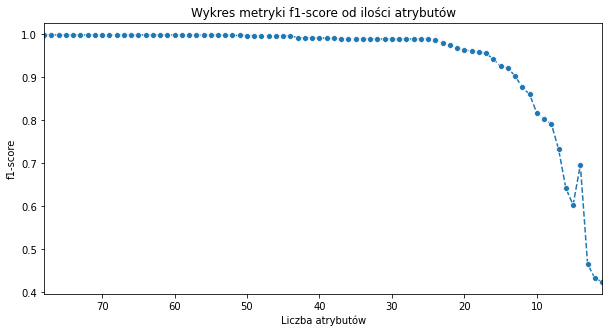

In [ ]:
evaluate_models(features_sobol, svm_models, model_builder=svm_builder(), amounts=1)

# 4. MLP

In [ ]:
mlp_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/Mushroom_MLP')

Shap

In [ ]:
mlp_shap_values = shap.KernelExplainer(mlp_model, Ksamples).shap_values(Ksamples)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
vals = np.array(mlp_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )
pickle.dump(features_shap, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_shap_mlp.sav', 'wb'))

                  waga
name                  
ring-type_g   0.000000
gill-color_e  0.000000
habitat_u     0.000000
cap-color_l   0.000000
habitat_w     0.000000
...                ...
cap-color_r   3.360768
has-ring_t    4.016296
cap-shape_f   4.269526
cap-shape_x   6.300505
stem-color_w  9.189477

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

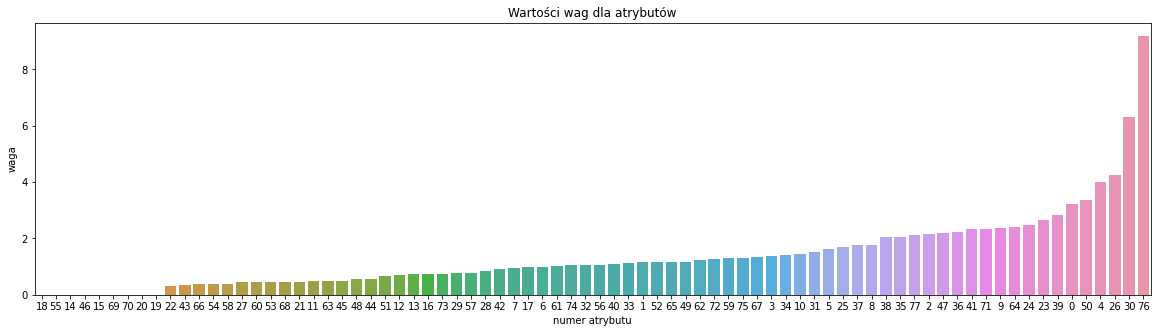

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.994356  0.995016  0.994718   0.994686
recall     0.993442  0.995691  0.994718   0.994567
f1-score   0.993890  0.995348  0.994718   0.994619

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.993171  0.995244  0.994317   0.994207
recall     0.993741  0.994755  0.994317   0.994248
f1-score   0.993437  0.994988  0.994317   0.994212

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.995308  0.993393  0.994196   0.994350
recall     0.991277  0.996422  0.994196   0.993849
f1-score   0.993273  0.994896  0.994196   0.994085

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.994072  0.997465  0.995989   0.995768
recall     0.996680  0.995463  0.995989   0.996071
f1-score   0.995372  0.996462  0.995989   0.995917

ilość atrybutów: 74
                  0         1  accuracy  macro av

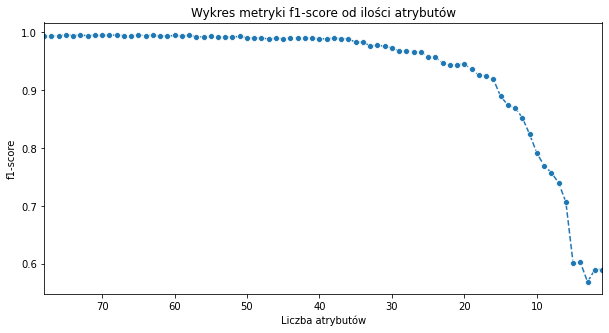

In [ ]:
mlp_models = []
for i in range( len(features_shap) ):
  mlp_models.append( create_mlp( len(features_shap)-i ) )

evaluate_models(features_shap, mlp_models, mlp_params, amounts=10)

Morris

In [ ]:
#param_values = saltelli.sample(problem, 1024)
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = mlp_model.predict(X)

20224/20224 [==============================] - 21s 1ms/step


In [ ]:
features_morris = get_morris_features(X, Y, problem)
print( features_morris )
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_morris_mlp.sav', 'wb'))

                  waga
stem-color_y  1.014403
cap-diameter  1.057921
stem-color_p  1.382268
habitat_d     1.382949
stem-color_e  1.384605
...                ...
stem-color_f  1.451682
stem-width    1.460058
habitat_w     1.467749
ring-type_m   1.476390
ring-type_z   1.496051

[78 rows x 1 columns]


In [ ]:
features_morris = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_morris_mlp.sav', 'rb'))
mlp_models = []
for i in range( len(features_morris) ):
  mlp_models.append( create_mlp( len(features_morris)-i ) )

Text(0.5, 0, 'numer atrybutu')

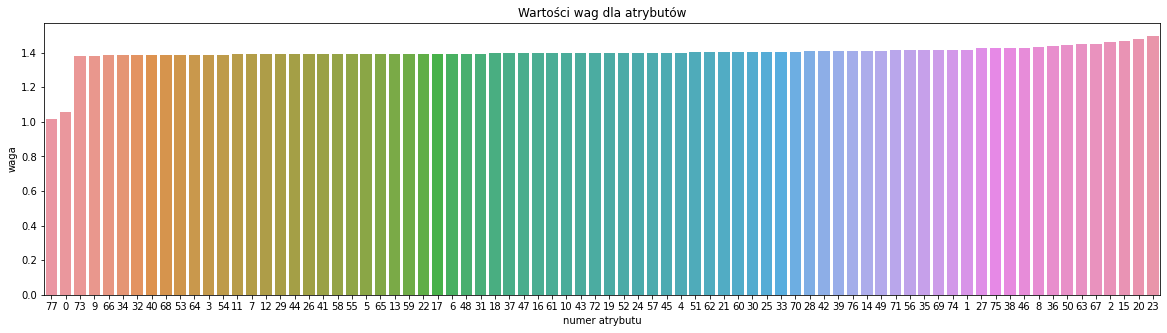

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.995353  0.996038  0.995735   0.995696
recall     0.994793  0.996454  0.995735   0.995623
f1-score   0.995068  0.996243  0.995735   0.995656

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.996201  0.995944  0.996052   0.996073
recall     0.994669  0.997106  0.996052   0.995888
f1-score   0.995432  0.996524  0.996052   0.995978

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.993386  0.992778  0.993009   0.993082
recall     0.990472  0.994944  0.993009   0.992708
f1-score   0.991906  0.993848  0.993009   0.992877

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.992843  0.992836  0.992818   0.992840
recall     0.990565  0.994535  0.992818   0.992550
f1-score   0.991688  0.993677  0.992818   0.992682

ilość atrybutów: 74
                  0         1  accuracy  macro av

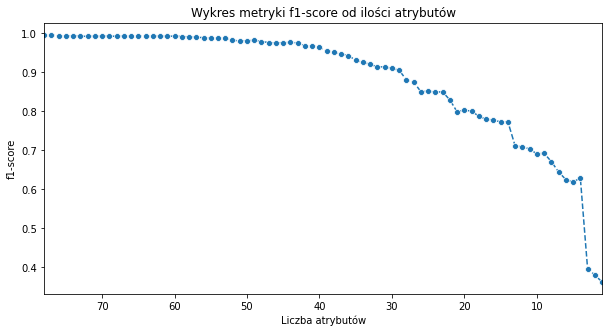

In [ ]:
evaluate_models(features_morris, mlp_models, mlp_params, amounts=10)

Sobol

In [ ]:
features_sobol = []

features_sobol.append(sobol.analyze(problem, Y.ravel())['ST'] )

features_sobol = np.abs(np.array(features_sobol))
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/MushroomModels/f_sobol_mlp.sav', 'wb'))

                  waga
cap-color_n   0.003183
habitat_d     0.003506
season_u      0.004828
stem-color_p  0.005048
habitat_m     0.005199
...                ...
cap-diameter  0.210007
stem-width    0.248849
ring-type_m   0.259372
habitat_w     0.285792
ring-type_z   0.288621

[78 rows x 1 columns]


Text(0.5, 0, 'numer atrybutu')

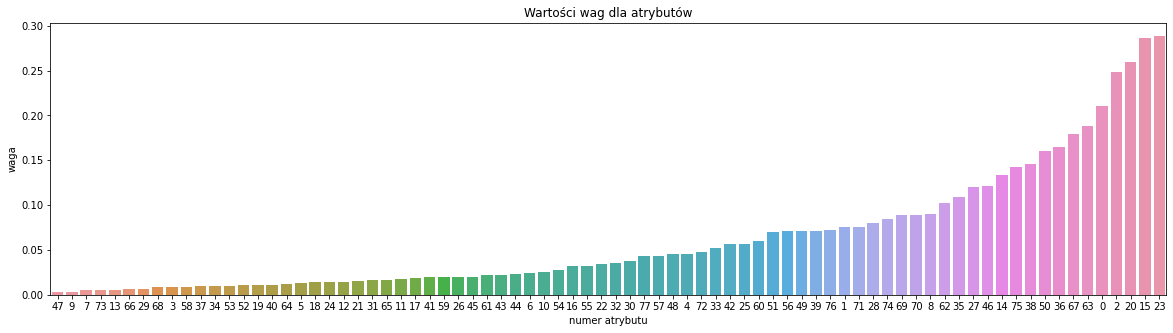

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 78
                  0         1  accuracy  macro avg
precision  0.994350  0.994681  0.994522   0.994515
recall     0.992999  0.995683  0.994522   0.994341
f1-score   0.993663  0.995176  0.994522   0.994419

ilość atrybutów: 77
                  0         1  accuracy  macro avg
precision  0.994478  0.996547  0.995637   0.995512
recall     0.995463  0.995770  0.995637   0.995616
f1-score   0.994961  0.996153  0.995637   0.995557

ilość atrybutów: 76
                  0         1  accuracy  macro avg
precision  0.993820  0.996784  0.995485   0.995302
recall     0.995772  0.995267  0.995485   0.995519
f1-score   0.994786  0.996019  0.995485   0.995403

ilość atrybutów: 75
                  0         1  accuracy  macro avg
precision  0.994125  0.995681   0.99499   0.994903
recall     0.994318  0.995502   0.99499   0.994910
f1-score   0.994210  0.995585   0.99499   0.994898

ilość atrybutów: 74
                  0         1  accuracy  macro av

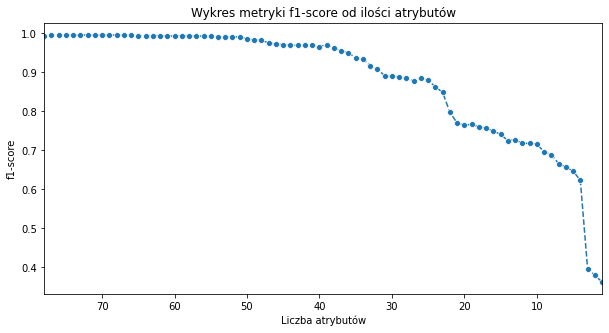

In [ ]:
evaluate_models(features_sobol, mlp_models, mlp_params, amounts=10)